# End-to-End Spoken Language Understanding 
- 원시 음성을 입력 받아 ASR(Automatic Speech Recognition) 도움 없이 해당 음성의 인텐트(intent)를 엔드투엔드(end-to-end)로 맞추는 모델
- 성능이 비교적 좋다.(현업에서 써봄직함.)

## E2E SLU
- Spoken Language Understanding(SLU)란 음성 입력의 인텐트를 맞추는 태스크를 가리킨다.
- End-to-End Spoken Language Understanding(E2E SLU) 모델의 지향점은 그림1과 같다.
- 입력 음성을 텍스트로 변환하는 ASR의 도움을 받아야 하는 기존 SLU 시스템과 달리 ASR없이 인텐트를 맞추는 것을 목표로 함.

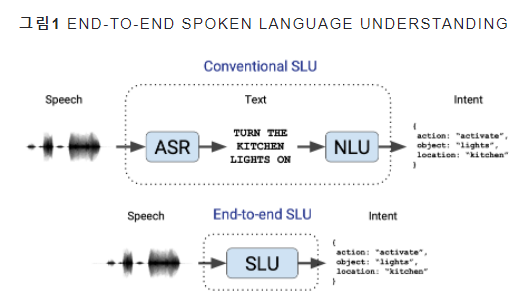

## Archtecture
- E2E SLU 전체 아키텍처는 그림2와 같다.
- 좌측 그림은 프리트레인(pretrain)을 도식화한 것이다.
- 음성을 입력 받아 음소(phoneme), 단어(word)를 각각 예측하는 과정에서 프리트레인을 한다.
- 프리트레인이 끝나면 음소, 단어 예측에 쓰였던 선형변환 레이어 2개(Phoneme Classifier, Word Classifier)를 제외하고, 인텐트를 맞추는 레이어를 하나 더 쌓아 SLU 데이터를 가지고 파인튜닝(fine-tuning)을 수행한다.

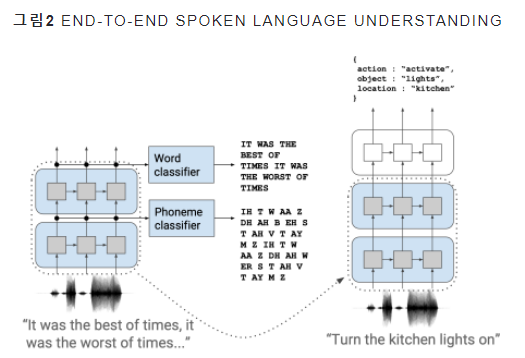

### Phoneme Layer에 대한 설명
- 그림2의 좌축 그림을 보면 원시 음성을 입력으로 받는다.
- 우선 싱크넷(sincnet, 컨볼루션 필터가 싱크 함수인 1D conv)를 쌓는다.
- 여기에 2개의 컨볼루션 레이어를 더 쌓고 그 위에 양방향 GRU(히든 차원수=128) 레이어 2개를 추가한다.
- GRU 레이어 사이사이에는 시퀀스 길이를 절반씩 줄이는 Downsample 레이어가 있다.
- 만약 첫번째 양방향 GRU 레이어의 프레임 시퀀스 길이가 28이라면 Downsample 레이어 통과 후 길이가 14(프레임 벡터 2개를 평균을 취해 절반으로 줄임)가 되고 14개의 프레임 시퀀스가 두번째 양방향 GRU레이어의 입력이 된다.
- 두번째 양방향 GRU레이어까지 계산을 마친 결과가 수식1의 $h^{phoneme}$가 된다.
- 이후 수식1처럼 선형변환을 수행해 로짓(logit) 벡터 $I^{phoneme}$를 만든다.
- 여기에 소프트맥스(softmax)를 취하고 해당 프레임의 음소 레이블과 비교해 손실(loss)을 계산한 뒤 역전파(backpropagation)를 수행해 프리트레인한다.

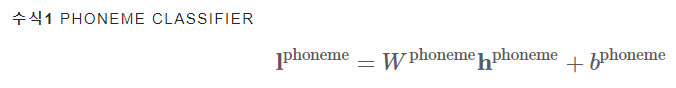

### Word Layer에 대한 설명
- Word Layer의 입력은 $h^{phoneme}$이다.
- Phoneme Layer 위에 양방향 GRU(히든 차원수=128) 레이어 2개를 쌓는다.
- GRU레이어 사이사이에는 Phoneme Layer처럼 프레임 벡터 2개의 평균을 취해 시퀀스 길이를 절반씩 줄이는 Downsample 레이어가 있다.
- Word Layer의 두번째 양방향 GRU레이어까지 계산을 마친 결과가 수식2의 $h^{word}$가 됨.
- 이후 선형 변환을 수행해 로짓 벡터 $I^{word}$를 만든다.
- 여기에 소프트맥스를 취하고 해당 프레임의 단어 레이블과 비교해 손실을 계산한 뒤 역전파를 수행해 프리트레인한다.

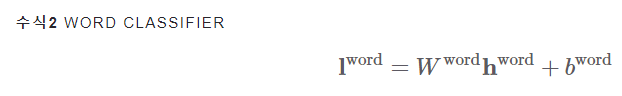

- 프리트레인을 마친 뒤 그림2의 Phoneme/Word Classifier는 제외하고 음성-인텐트 조합의 SLU데이터로 파인튜닝을 수행한다.
- 파인튜닝 때는 그림2 우측 최상단의 Intent Module이 추가된다.
- 이 모듈의 입력은 $h^{word}$
- E2E SLU의 성능이 좋은 이유는 음소, 단어 레벨의 정보를 모델 전체에 녹이기 때문으로 풀이됨.
- 보통의 모델은 음소 혹은 단어 둘 중 하나만 사용하는 경향이 있는데 E2E SLU에서는 인텐트 분류에 중요한 역할을 수행하는 텍스트 정보를 적극적으로 활용하기 때문에 좋은 성능을 내는 것 같다.

## Data Preparation
- E2E SLU 모델을 프리트레인하려면 음성-음소, 음성-단어 경계를 나눈 결과, 즉 Forced Alignment 정보(TextGrid파일)가 필요하다.
- 이는 Hidden Markov Model 기반의 전통적인 방식으로 만들 수도 있고, Connectionist Temporal Classification방식으로 학습한 딥러닝 기반의 시퀀스 모델로 만들 수도 있다.

In [ ]:
## ASRDATASET

import torch.utils.data
import soundfile as sf
import textgrid

class ASRDataset(torch.utils.data.Dataset):

    def __getitem__(self, idx):
        x, fs = sf.read(self.wav_paths[idx])

        tg = textgrid.TextGrid()
        tg.read(self.textgrid_paths[idx])

        y_phoneme = []
        for phoneme in tg.getList("phones")[0]:
            duration = phoneme.maxTime - phoneme.minTime
            phoneme_index = self.Sy_phoneme.index(phoneme.mark.rstrip("0123456789")) if phoneme.mark.rstrip("0123456789") in self.Sy_phoneme else -1
            if phoneme.mark == ' ': phoneme_index = -1
            y_phoneme += [phoneme_index] * round(duration * fs)

        y_word = []
        for word in tg.getList("words")[0]:
            duration = word.maxTime - word.minTime
            word_index = self.Sy_word.index(word.mark) if word.mark in self.Sy_word else -1
            y_word += [word_index] * round(duration * fs)

        random_length = round(fs * max(self.length_mean + self.length_var * torch.randn(1).item(), 0.5))
        if len(x) <= random_length:
            start = 0
        else:
            start = torch.randint(low=0, high=len(x)-random_length, size=(1,)).item()
        end = start + random_length

        x = x[start:end]
        y_phoneme = y_phoneme[start:end:self.phone_downsample_factor]
        y_word = y_word[start:end:self.word_downsample_factor]

        return (x, y_phoneme, y_word)

- 그런데 음성 샘플(int)은 싱크넷(sincnet)과 phoneme, word layer를 통과하면서 그 길이가 점점 줄어들어 프레임 벡터 시퀀스로 변환된다.
- E2E SLU의 경우 음성 샘플(int) 640개(phone_downsample_factor)가 하나의 음소 프레임(frame)벡터를, 음성 샘플 2560개(word_downsample_factor)가 하나의 단어 프레임 벡터를 구성한다.
- 우리는 프레임 벡터 각각에 레이블 정보를 주기만 하면 되므로, y_phoneme을 만들 때는 뻥튀기된 레이블 시퀀스에서 phone_downsample_factor만큼 띄엄띄엄 레이블을 만들면 된다.
- 최종적으로 y_phoneme에 포함되는 'd'레이블 수는 1120/640, 즉 1개가 된다.
- 마찬가지로 y_word에 포함되는 '대만'레이블 수는 5439/2560, 즉 2개가 된다.

## Experiments
- 그림3은 SLU 데이터셋에 대한 파인튜닝 성능을 정리한 것
- 프리트레인하고 파인튜닝한 모델이 from scratch로 파인튜닝한 모델보다 성능이 좋다.
- 프리트레인을 수행한 모델들 가운데서도 'Unfreeze word layers'의 성능이 눈에 띈다.
- 이 모델은 파인튜닝할 때 Phoneme Layer는 고정(freeze)하고, Word Layer만 학습한 것 => Phoneme/Word Layer 모두 학습한 모델만큼의 성적을 내고 있다.
- 파인튜닝을 Word Layer만 해도 원하는 성능을 낼 수 있다.
- 학습 속도를 높이고 계산량을 줄인다는 점에서 주목할 만하다.

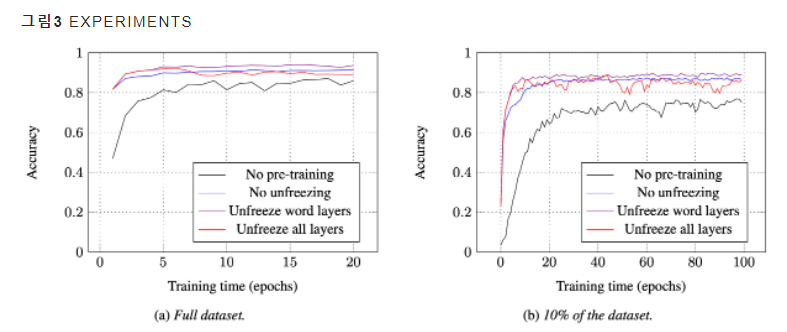